In [320]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [321]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [322]:
df = pd.read_csv('/kaggle/input/datasets/taeefnajib/used-car-price-prediction-dataset/used_cars.csv')

# Первичный осмотр данных

In [323]:
df.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
5,Acura,ILX 2.4L,2016,"136,397 mi.",Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,NaN,"$14,798"
6,Audi,S3 2.0T Premium Plus,2017,"84,000 mi.",Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,"$31,000"
7,BMW,740 iL,2001,"242,000 mi.",Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,"$7,300"
8,Lexus,RC 350 F Sport,2021,"23,436 mi.",Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,"$41,927"
9,Tesla,Model X Long Range Plus,2020,"34,000 mi.",NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,"$69,950"


In [324]:
df.shape

(4009, 12)

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [326]:
df.describe()

,model_year
count,4009.00
mean,2015.52
std,6.10
min,1974.00
25%,2012.00
50%,2017.00
75%,2020.00
max,2024.00


Отсюда сразу видно, что пробег и стоимость заданы как object, их надо привести к числовому типу

In [327]:
df = df.rename(columns={'milage': 'mileage'})

df['mileage'] = df['mileage'].str.replace(' mi.', '').str.replace(',', '')
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

df['price'] = df['price'].str.replace('$', '').str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [328]:
df.describe()

,model_year,mileage,price
count,4009.00,4009.00,4009.00
mean,2015.52,64717.55,44553.19
std,6.10,52296.60,78710.64
min,1974.00,100.00,2000.00
25%,2012.00,23044.00,17200.00
50%,2017.00,52775.00,31000.00
75%,2020.00,94100.00,49990.00
max,2024.00,405000.00,2954083.00


In [329]:
df.isnull().sum()

brand             0
model             0
model_year        0
mileage           0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [330]:
cat_cols = df.select_dtypes(include=['object']).columns
for c in cat_cols:
    print(c, df[c].nunique())

brand 57
model 1898
fuel_type 7
engine 1146
transmission 62
ext_col 319
int_col 156
accident 2
clean_title 1


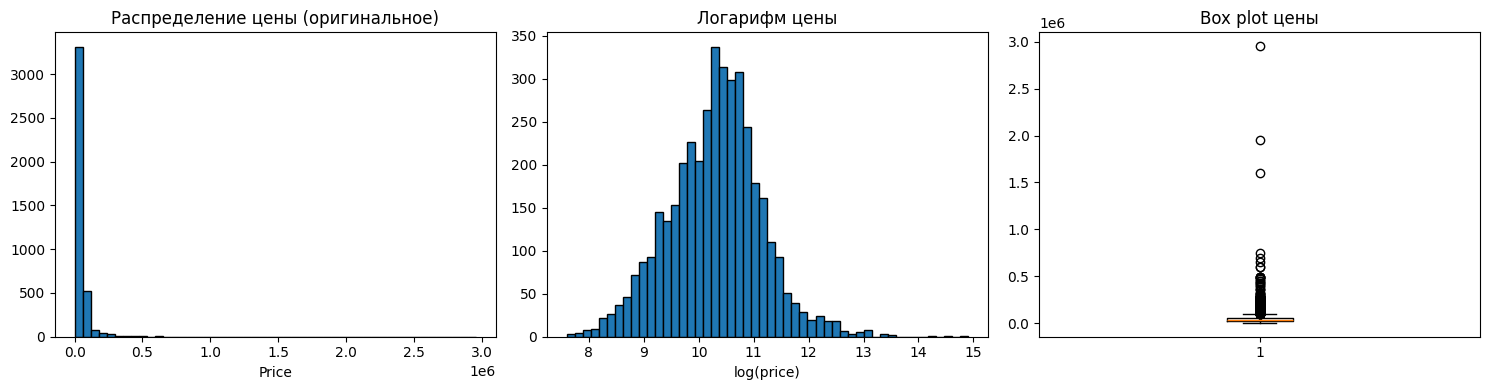

In [331]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['price'], bins=50, edgecolor='black')
axes[0].set_title('Распределение цены (оригинальное)')
axes[0].set_xlabel('Price')

axes[1].hist(np.log1p(df['price']), bins=50, edgecolor='black')
axes[1].set_title('Логарифм цены')
axes[1].set_xlabel('log(price)')

axes[2].boxplot(df['price'])
axes[2].set_title('Box plot цены')

plt.tight_layout()
plt.show()

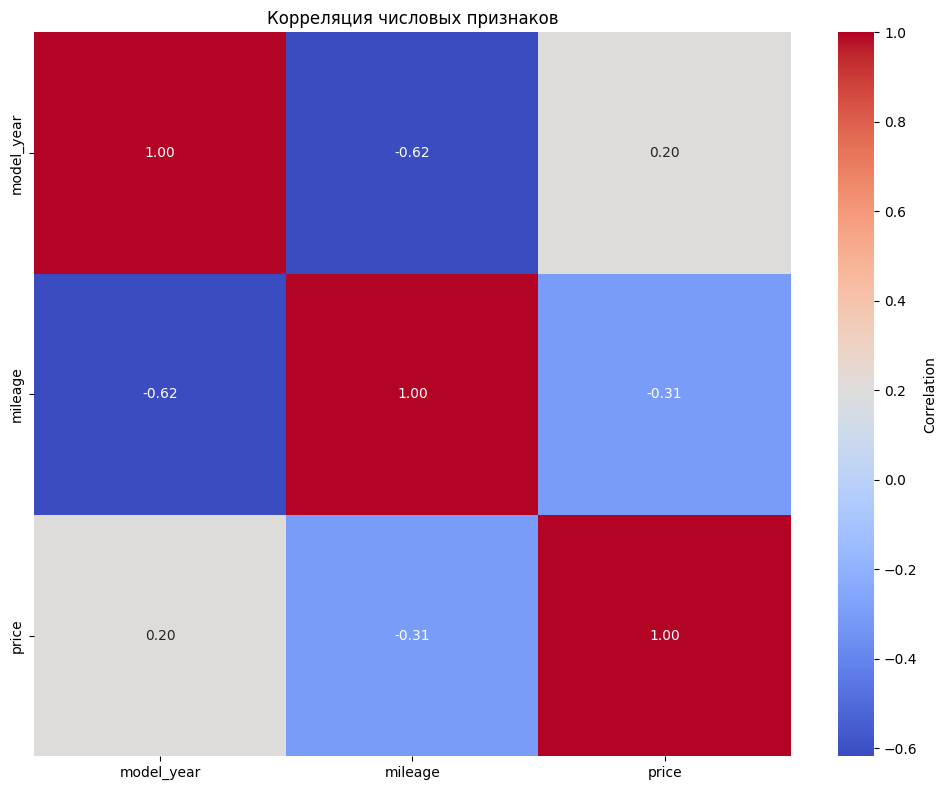

In [332]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title("Корреляция числовых признаков")
plt.tight_layout()
plt.show()

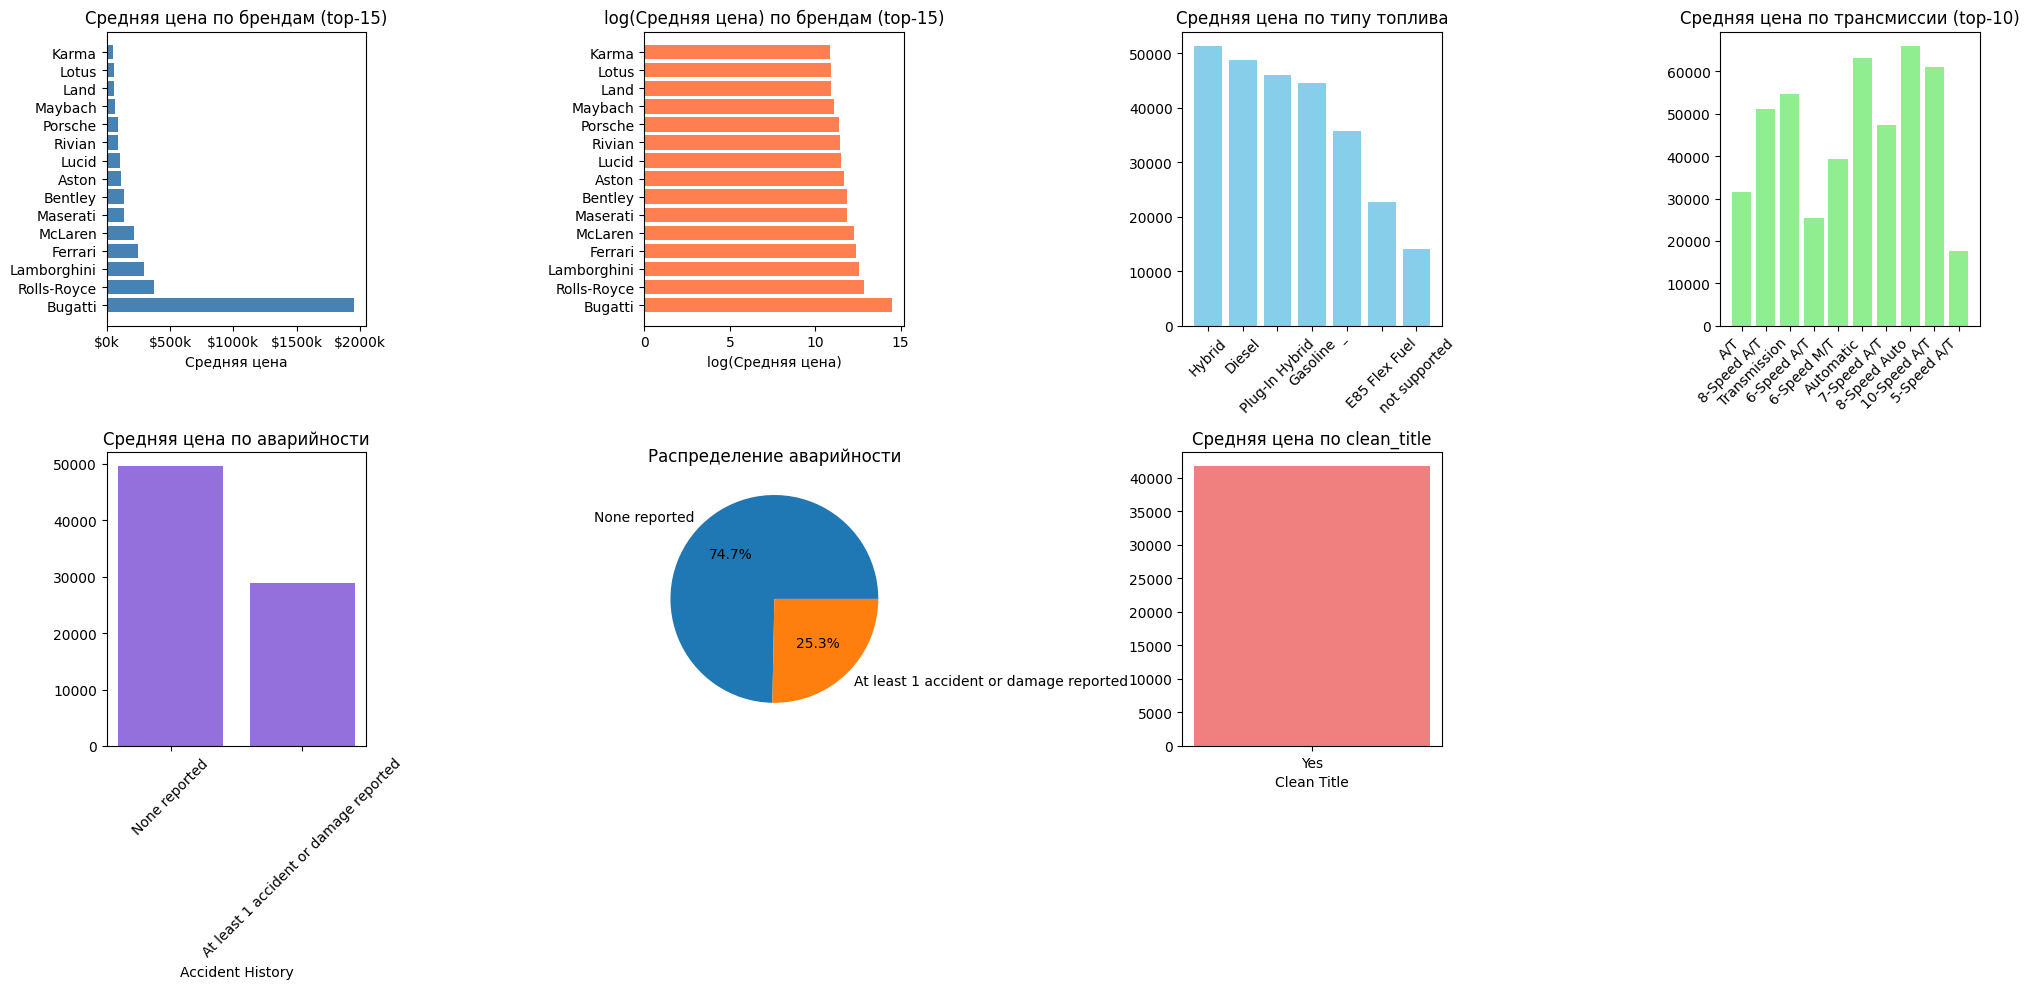

In [333]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

brand_price = df.groupby('brand')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
axes[0,0].barh(brand_price.index[:15], brand_price['mean'][:15], color='steelblue')
axes[0,0].set_title('Средняя цена по брендам (top-15)')
axes[0,0].set_xlabel('Средняя цена')
axes[0,0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x/1000)}k'))

axes[0,1].barh(brand_price.index[:15], np.log1p(brand_price['mean'][:15]), color='coral')
axes[0,1].set_title('log(Средняя цена) по брендам (top-15)')
axes[0,1].set_xlabel('log(Средняя цена)')

fuel_price = df.groupby('fuel_type')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
axes[0,2].bar(fuel_price.index, fuel_price['mean'], color='skyblue')
axes[0,2].set_title('Средняя цена по типу топлива')
axes[0,2].tick_params(axis='x', rotation=45)

trans_price = df.groupby('transmission')['price'].agg(['mean', 'count']).sort_values('count', ascending=False).head(10)
axes[0,3].bar(range(len(trans_price)), trans_price['mean'], color='lightgreen')
axes[0,3].set_title('Средняя цена по трансмиссии (top-10)')
axes[0,3].set_xticks(range(len(trans_price)))
axes[0,3].set_xticklabels([x[:12] for x in trans_price.index], rotation=45, ha='right')

accident_price = df.groupby('accident')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
axes[1,0].bar(accident_price.index, accident_price['mean'], color='mediumpurple')
axes[1,0].set_title('Средняя цена по аварийности')
axes[1,0].set_xlabel('Accident History')
axes[1,0].tick_params(axis='x', rotation=45)

accident_counts = df['accident'].value_counts()
axes[1,1].pie(accident_counts.values, labels=accident_counts.index, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
axes[1,1].set_title('Распределение аварийности')

clean_price = df.groupby('clean_title')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
axes[1,2].bar(clean_price.index.astype(str), clean_price['mean'], color='lightcoral')
axes[1,2].set_title('Средняя цена по clean_title')
axes[1,2].set_xlabel('Clean Title')

axes[1,3].axis('off')  

plt.tight_layout()
plt.show()

In [334]:
print(f"Уникальные значения: {df['clean_title'].nunique()}")
print(f"Значения в clean_title:")
print(df['clean_title'].value_counts(dropna=False))
print(f"\nПропуски: {df['clean_title'].isnull().sum()}")

Уникальные значения: 1
Значения в clean_title:
clean_title
Yes    3413
NaN     596
Name: count, dtype: int64

Пропуски: 596


## Гипотезы

1. Оригинальная цена очень асимметрична, а логарифм близок к нормальному распределению, поэтому логарифмирование целевой переменной улучшит $R^2$ линейной регрессии

2. Макс цена сейчас 2954083.00, это очевидно выброс, и его удаление улучшит метрики, тк модель не будет учиться на аномалиях

3. Корреляции числовых признаков маленькие, поэтому, возможно, дерево или лес покажет лучшие результаты, чем линрег

4. Ridge регрессия превзойдет OLS, тк model_year и milage коррелируют с коэф. -0.62, то есть присутствует мультиколлинеарность

5. clean_title никак не варьируется, поэтому в обучении никак не поможет, дропаем

   

# Препроцессинг

In [335]:
df_prep = df.copy()

## Ценовой анализ машин и обработка возможных выбросов

In [336]:
df_prep['price'].describe()

count      4009.00
mean      44553.19
std       78710.64
min        2000.00
25%       17200.00
50%       31000.00
75%       49990.00
max     2954083.00
Name: price, dtype: float64

In [337]:
Q1 = df_prep['price'].quantile(0.25)
Q3 = df_prep['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"  Q1 (25%): ${Q1:,.0f}")
print(f"  Q3 (75%): ${Q3:,.0f}")
print(f"  IQR: ${IQR:,.0f}")
print(f"  Lower bound: ${lower_bound:,.0f}")
print(f"  Upper bound: ${upper_bound:,.0f}")


outliers = df_prep[(df_prep['price'] < lower_bound) | (df_prep['price'] > upper_bound)]
print(f"\nНайдено выбросов: {len(outliers)} ({len(outliers)/len(df_prep)*100:.2f}%)")
print(f"  Цены выбросов: ${outliers['price'].min():,.0f} - ${outliers['price'].max():,.0f}")

  Q1 (25%): $17,200
  Q3 (75%): $49,990
  IQR: $32,790
  Lower bound: $-31,985
  Upper bound: $99,175

Найдено выбросов: 244 (6.09%)
  Цены выбросов: $99,750 - $2,954,083


In [338]:
top_30_expensive = df_prep.nlargest(30, 'price')[['brand', 'model', 'model_year', 'mileage', 'price']]

In [339]:
top_30_expensive

,brand,model,model_year,mileage,price
693,Maserati,Quattroporte Base,2005,32000,2954083
229,Bugatti,Veyron 16.4 Grand Sport,2011,6330,1950995
3046,Porsche,Carrera GT Base,2005,4400,1599000
1356,Lamborghini,Aventador SVJ Base,2021,6987,749950
624,Rolls-Royce,Cullinan,2022,398,695000
979,Lamborghini,Aventador SVJ Base,2019,6929,649999
1615,Rolls-Royce,Phantom,2023,1560,599995
1508,Rolls-Royce,Phantom,2018,7585,599000
3655,Lamborghini,Aventador S Base,2018,5858,491836
1061,Dodge,Viper GTC,2017,1389,489995


In [340]:
price_ranges = {
    "$0-20k": (0, 20000),
    "$20-50k": (20000, 50000),
    "$50-100k": (50000, 100000),
    "$100-200k": (100000, 200000),
    "$200-500k": (200000, 500000),
    "$500k-$1M": (500000, 1000000),
    "$1M-$3M": (1000000, 3000000),
    "$3M+": (3000000, float('inf'))
}

for range_name, (lower, upper) in price_ranges.items():
    count = len(df_prep[(df_prep['price'] >= lower) & (df_prep['price'] < upper)])
    pct = count / len(df_prep) * 100
    print(f"{range_name:20} : {count:4} машин ({pct:5.2f}%)")

$0-20k               : 1231 машин (30.71%)
$20-50k              : 1794 машин (44.75%)
$50-100k             :  749 машин (18.68%)
$100-200k            :  159 машин ( 3.97%)
$200-500k            :   68 машин ( 1.70%)
$500k-$1M            :    5 машин ( 0.12%)
$1M-$3M              :    3 машин ( 0.07%)
$3M+                 :    0 машин ( 0.00%)


In [341]:
expensive_brands = df_prep[df_prep['price'] > 100000]['brand'].value_counts()
print(f"\nМашины дороже $100k - какие бренды?")
print(expensive_brands)


Машины дороже $100k - какие бренды?
brand
Porsche          53
Mercedes-Benz    36
Lamborghini      25
Bentley          20
Land             16
Audi             11
Ferrari          11
BMW              11
Rolls-Royce       9
Cadillac          7
McLaren           6
Aston             4
Dodge             4
Nissan            4
Lexus             4
Maserati          4
Chevrolet         3
Ford              2
Lucid             1
Bugatti           1
Acura             1
GMC               1
Name: count, dtype: int64


In [342]:
brand_avg_price = df_prep.groupby('brand')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
brand_avg_price.head()

,mean,count
brand,,
Bugatti,1950995.00,1
Rolls-Royce,370992.73,11
Lamborghini,291233.85,26
Ferrari,243790.67,12
McLaren,213457.50,6


я решил удалить машины дороже 500к долларов, потому что записей все равно мало

In [343]:
df_prep = df_prep[df_prep['price'] <= 500000]

## Удаление лишних фич и обработка пропусков

In [344]:
df_prep = df_prep.drop(['clean_title', 'model', 'engine'], axis=1)

clean_title не меняется, а в model слишком много значений

In [345]:
print("\n fuel_type:")
print(f"   Всего записей: {len(df_prep)}")
print(f"   Пропусков: {df_prep['fuel_type'].isnull().sum()}")
print(f"   % пропусков: {df_prep['fuel_type'].isnull().sum() / len(df_prep) * 100:.2f}%")
print(f"\n   Распределение значений:")
print(df_prep['fuel_type'].value_counts())
print(f"\n   Мода: {df_prep['fuel_type'].mode()[0]}")


 fuel_type:
   Всего записей: 4001
   Пропусков: 170
   % пропусков: 4.25%

   Распределение значений:
fuel_type
Gasoline          3302
Hybrid             194
E85 Flex Fuel      139
Diesel             116
–                   44
Plug-In Hybrid      34
not supported        2
Name: count, dtype: int64

   Мода: Gasoline


In [346]:
print("\n accident:")
print(f"   Всего записей: {len(df_prep)}")
print(f"   Пропусков: {df_prep['accident'].isnull().sum()}")
print(f"   % пропусков: {df_prep['accident'].isnull().sum() / len(df_prep) * 100:.2f}%")
print(f"\n   Распределение значений:")
print(df_prep['accident'].value_counts(dropna=False))


 accident:
   Всего записей: 4001
   Пропусков: 113
   % пропусков: 2.82%

   Распределение значений:
accident
None reported                             2903
At least 1 accident or damage reported     985
NaN                                        113
Name: count, dtype: int64


Так как по типу топлива пропусков мало, то логичнее всего будет заполнить наны модой. С авариями тоже мало пропусков, но по логике можно сказать, что если значения нет, то скорее всего аварии действительно не было, поэтому можно заполнить "None reported"

In [347]:
df_prep['fuel_type'].fillna(df_prep['fuel_type'].mode()[0], inplace=True)

In [348]:
df_prep['accident'].fillna('None reported', inplace=True) 

## Target Encoding цветов

In [349]:
ext_col_mean = df_prep.groupby('ext_col')['price'].mean()
int_col_mean = df_prep.groupby('int_col')['price'].mean()

In [350]:
df_prep['ext_col_encoded'] = df_prep['ext_col'].map(ext_col_mean)
df_prep['int_col_encoded'] = df_prep['int_col'].map(int_col_mean)

In [351]:
df_prep = df_prep.drop(['ext_col', 'int_col'], axis=1)

## Группировка типов трансмиссии

беру самые популярные, остальные в other

In [352]:
top_trans = df_prep['transmission'].value_counts().head(8).index

In [353]:
df_prep['transmission'] = df_prep['transmission'].apply(
    lambda x: x if x in top_trans else 'Other'
)

## OHE кат признаков

In [354]:
cat_features = ['brand', 'fuel_type', 'transmission', 'accident']
df_encoded = pd.get_dummies(df_prep, columns=cat_features, drop_first=True)

## Логарифмирование цены

In [355]:
df_encoded['price_log'] = np.log1p(df_encoded['price'])


# Подготовка данных для моделей

In [356]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [357]:
X = df_encoded.drop(['price', 'price_log'], axis=1)
y_log = df_encoded['price_log']
y_original = df_encoded['price']

In [358]:
print(f"   Признаки: {X.shape}")
print(f"   Целевая переменная: {y_log.shape}")

   Признаки: (4001, 74)
   Целевая переменная: (4001,)


## масштабирование

In [359]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

train test split

In [360]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)

In [361]:
print(f"   Train: {X_train.shape[0]} записей")
print(f"   Test: {X_test.shape[0]} записей")

   Train: 3200 записей
   Test: 801 записей


# Обучение бейзлайн моделей

In [362]:
results = {}

## линейная регрессия

In [363]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr_train = lr.predict(X_train)
y_pred_lr_test = lr.predict(X_test)

In [364]:
lr_train_r2 = r2_score(y_train, y_pred_lr_train)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)
lr_test_mae = mean_absolute_error(y_test, y_pred_lr_test)

print(f"   Train R²: {lr_train_r2:.4f}")
print(f"   Test R²:  {lr_test_r2:.4f}")
print(f"   Test MAE: {lr_test_mae:.4f}")

   Train R²: 0.7645
   Test R²:  0.7387
   Test MAE: 0.3037


In [365]:
results['LinearRegression'] = {'train_r2': lr_train_r2, 'test_r2': lr_test_r2, 'mae': lr_test_mae}

## ridge регрессия

In [366]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge_train = ridge.predict(X_train)
y_pred_ridge_test = ridge.predict(X_test)

In [367]:
ridge_train_r2 = r2_score(y_train, y_pred_ridge_train)
ridge_test_r2 = r2_score(y_test, y_pred_ridge_test)
ridge_test_mae = mean_absolute_error(y_test, y_pred_ridge_test)

print(f"   Train R²: {ridge_train_r2:.4f}")
print(f"   Test R²:  {ridge_test_r2:.4f}")
print(f"   Test MAE: {ridge_test_mae:.4f}")

   Train R²: 0.7645
   Test R²:  0.7387
   Test MAE: 0.3037


In [368]:
results['Ridge(α=1.0)'] = {'train_r2': ridge_train_r2, 'test_r2': ridge_test_r2, 'mae': ridge_test_mae}

## lasso

In [370]:
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_lasso_train = lasso.predict(X_train)
y_pred_lasso_test = lasso.predict(X_test)

In [371]:
lasso_train_r2 = r2_score(y_train, y_pred_lasso_train)
lasso_test_r2 = r2_score(y_test, y_pred_lasso_test)
lasso_test_mae = mean_absolute_error(y_test, y_pred_lasso_test)

print(f"   Train R²: {lasso_train_r2:.4f}")
print(f"   Test R²:  {lasso_test_r2:.4f}")
print(f"   Test MAE: {lasso_test_mae:.4f}")

   Train R²: 0.7513
   Test R²:  0.7329
   Test MAE: 0.3123


In [372]:
results['Lasso(α=0.01)'] = {'train_r2': lasso_train_r2, 'test_r2': lasso_test_r2, 'mae': lasso_test_mae}

## решающее дерево

In [373]:
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt_train = dt.predict(X_train)
y_pred_dt_test = dt.predict(X_test)

In [374]:
dt_train_r2 = r2_score(y_train, y_pred_dt_train)
dt_test_r2 = r2_score(y_test, y_pred_dt_test)
dt_test_mae = mean_absolute_error(y_test, y_pred_dt_test)

print(f"   Train R²: {dt_train_r2:.4f}")
print(f"   Test R²:  {dt_test_r2:.4f}")
print(f"   Test MAE: {dt_test_mae:.4f}")

   Train R²: 0.8196
   Test R²:  0.6183
   Test MAE: 0.3705


In [375]:
results['DecisionTree(d=10)'] = {'train_r2': dt_train_r2, 'test_r2': dt_test_r2, 'mae': dt_test_mae}

## random forest

In [376]:
rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

In [377]:
rf_train_r2 = r2_score(y_train, y_pred_rf_train)
rf_test_r2 = r2_score(y_test, y_pred_rf_test)
rf_test_mae = mean_absolute_error(y_test, y_pred_rf_test)

print(f"   Train R²: {rf_train_r2:.4f}")
print(f"   Test R²:  {rf_test_r2:.4f}")
print(f"   Test MAE: {rf_test_mae:.4f}")

   Train R²: 0.9183
   Test R²:  0.7337
   Test MAE: 0.3078


In [378]:
results['RandomForest'] = {'train_r2': rf_train_r2, 'test_r2': rf_test_r2, 'mae': rf_test_mae}

## градиентный бустинг

In [379]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb_train = gb.predict(X_train)
y_pred_gb_test = gb.predict(X_test)

In [380]:
gb_train_r2 = r2_score(y_train, y_pred_gb_train)
gb_test_r2 = r2_score(y_test, y_pred_gb_test)
gb_test_mae = mean_absolute_error(y_test, y_pred_gb_test)

print(f"   Train R²: {gb_train_r2:.4f}")
print(f"   Test R²:  {gb_test_r2:.4f}")
print(f"   Test MAE: {gb_test_mae:.4f}")

   Train R²: 0.8466
   Test R²:  0.7662
   Test MAE: 0.2926


In [381]:
results['GradientBoosting'] = {'train_r2': gb_train_r2, 'test_r2': gb_test_r2, 'mae': gb_test_mae}

## сравнение результатов

In [382]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('test_r2', ascending=False)
print("\n" + results_df.to_string())

print("\nЛучшая модель по Test R^2:", results_df.index[0])


                    train_r2  test_r2  mae
GradientBoosting        0.85     0.77 0.29
Ridge(α=1.0)            0.76     0.74 0.30
LinearRegression        0.76     0.74 0.30
RandomForest            0.92     0.73 0.31
Lasso(α=0.01)           0.75     0.73 0.31
DecisionTree(d=10)      0.82     0.62 0.37

Лучшая модель по Test R^2: GradientBoosting
